# Grafice Ilustrative pentru ecuatiile luminii

## Importare biblioteci necesare

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch, torch.nn as nn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
Path("plots").mkdir(exist_ok=True)
Path("data").mkdir(exist_ok=True)
plt.style.use('seaborn-v0_8-whitegrid')

## Reflexie

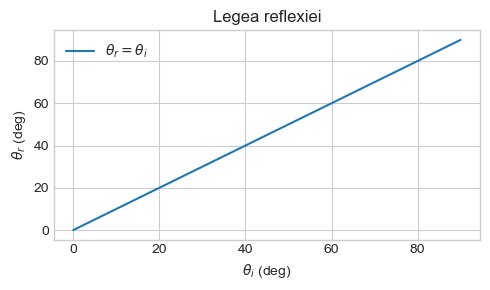

In [3]:
theta_i = np.linspace(0, 90, 500)
theta_r = theta_i
plt.figure(figsize=(5, 3))
plt.plot(theta_i, theta_r, label=r"$\theta_r = \theta_i$", color="C0")
plt.xlabel(r"$\theta_i$ (deg)")
plt.ylabel(r"$\theta_r$ (deg)")
plt.title("Legea reflexiei")
plt.legend()
plt.tight_layout()
plt.savefig("plots/reflection.png", dpi=300)

## Refractie

In [4]:
def build_snell_dataset(n=1000):
    rng = np.random.default_rng(42)
    n1 = rng.uniform(1.0, 1.5, n)
    n2 = rng.uniform(1.3, 2.0, n)
    theta1_deg = rng.uniform(0, 80, n)
    theta1_rad = np.radians(theta1_deg)

    # evităm total-reflexia: sinθ₁ ≤ n₂/n₁
    sin_max = n2 / n1
    mask = np.sin(theta1_rad) <= sin_max
    n1, n2, theta1_deg, theta1_rad = n1[mask], n2[mask], theta1_deg[mask], theta1_rad[mask]

    theta2_rad = np.arcsin((n1 / n2) * np.sin(theta1_rad))
    theta2_deg = np.degrees(theta2_rad)

    return pd.DataFrame({"n1": n1, "n2": n2, "theta1": theta1_deg, "theta2": theta2_deg})

/var/folders/v9/l8dwmpq12gz43xchbrk2wxh80000gn/T/ipykernel_9716/1244931108.py:14: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/v9/l8dwmpq12gz43xchbrk2wxh80000gn/T/ipykernel_9716/1244931108.py:15: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig("plots/snell_ml.png", dpi=300)
/usr/local/Caskroom/miniforge/base/envs/manim-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


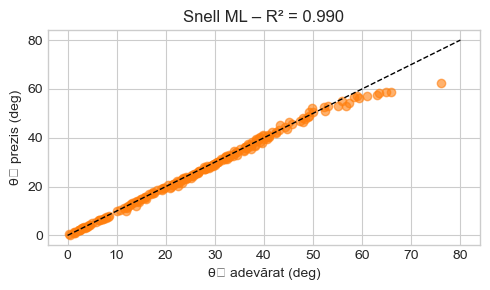

In [5]:

df = build_snell_dataset()
X = df[["n1", "n2", "theta1"]].values
y = df["theta2"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = MLPRegressor(hidden_layer_sizes=(32,32), max_iter=2000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred, alpha=0.6, color="C1")
plt.plot([0, 80], [0, 80], "k--", lw=1)
plt.xlabel("θ₂ adevărat (deg)")
plt.ylabel("θ₂ prezis (deg)")
plt.title(f"Snell ML – R² = {r2_score(y_test, y_pred):.3f}")
plt.tight_layout()
plt.savefig("plots/snell_ml.png", dpi=300)

## Difractie

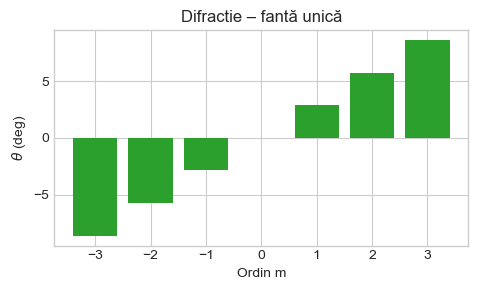

In [6]:
m = np.arange(-3, 4)
lam = 500e-9  # 500 nm
d = 10e-6   # 10 µm
theta = np.degrees(np.arcsin(m * lam / d))
plt.figure(figsize=(5, 3))
plt.bar(m, theta, color="C2")
plt.xlabel("Ordin m")
plt.ylabel(r"$\theta$ (deg)")
plt.title("Difractie – fantă unică")
plt.tight_layout()
plt.savefig("plots/diffraction.png", dpi=300)

## Interferenta 2 Fante

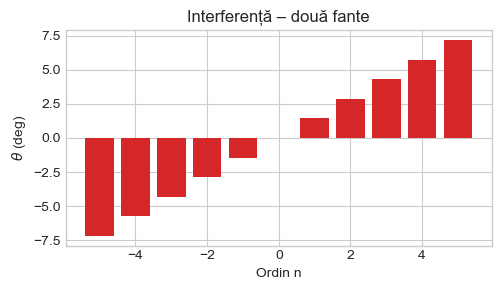

In [7]:
n = np.arange(-5, 6)
lam = 500e-9
d = 20e-6
theta = np.degrees(np.arcsin(n * lam / d))
plt.figure(figsize=(5, 3))
plt.bar(n, theta, color="C3")
plt.xlabel("Ordin n")
plt.ylabel(r"$\theta$ (deg)")
plt.title("Interferență – două fante")
plt.tight_layout()
plt.savefig("plots/interference.png", dpi=300)

## Unda electromagnetica

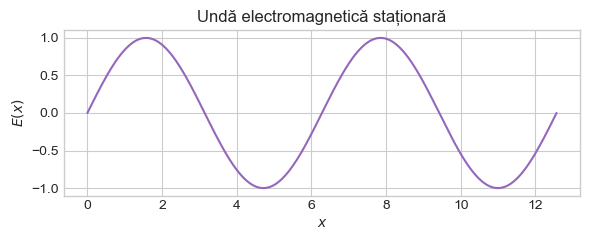

In [8]:
x = np.linspace(0, 4 * np.pi, 500)
E = np.sin(x)
plt.figure(figsize=(6, 2.5))
plt.plot(x, E, color="C4")
plt.xlabel(r"$x$")
plt.ylabel(r"$E(x)$")
plt.title("Undă electromagnetică staționară")
plt.tight_layout()
plt.savefig("plots/wave_em.png", dpi=300)

## Energie Foton

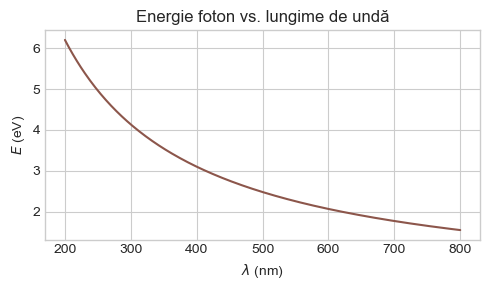

In [9]:
lam = np.linspace(200e-9, 800e-9, 300)  # 200-800 nm
E = 6.626e-34 * 3e8 / lam / 1.602e-19  # eV
plt.figure(figsize=(5, 3))
plt.plot(lam * 1e9, E, color="C5")
plt.xlabel(r"$\lambda$ (nm)")
plt.ylabel(r"$E$ (eV)")
plt.title("Energie foton vs. lungime de undă")
plt.tight_layout()
plt.savefig("plots/photon_energy.png", dpi=300)

## Regresie cu constrangere Snell

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def make_data(n=2000):
    rng = np.random.default_rng(42)
    n1 = rng.uniform(1.0, 1.5, n)
    n2 = rng.uniform(1.3, 2.0, n)
    t1 = rng.uniform(0, 75, n)
    sin_t1 = np.sin(np.radians(t1))
    sin_max = n2 / n1
    mask = sin_t1 <= sin_max
    n1, n2, t1, sin_t1 = n1[mask], n2[mask], t1[mask], sin_t1[mask]
    sin_t2 = sin_t1 * n1 / n2
    t2 = np.degrees(np.arcsin(sin_t2))
    return pd.DataFrame({"n1": n1, "n2": n2, "theta1": t1, "theta2": t2})

In [11]:
df = make_data()
X, y = df[["n1", "n2", "theta1"]].values, df["theta2"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_s, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32, device=device)
y_test_t  = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)

In [12]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)
    def physics_loss(self, x):
        n1, n2, t1 = x[:, 0], x[:, 1], x[:, 2]
        t2 = self.forward(x).squeeze()
        sin_t1 = torch.sin(torch.deg2rad(t1))
        sin_t2 = torch.sin(torch.deg2rad(t2))
        return torch.mean((sin_t1 * n1 - sin_t2 * n2)**2)

In [13]:
model = PINN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

for epoch in range(800):
    opt.zero_grad()
    pred = model(X_train_t)
    data_loss = mse(pred, y_train_t)
    phys_loss = model.physics_loss(X_train_t)
    loss = data_loss + 0.1 * phys_loss
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print(f"Ep {epoch:3d} | data-loss {data_loss.item():.4f} | phys-loss {phys_loss.item():.4f}")

Ep   0 | data-loss 941.0013 | phys-loss 0.0003
Ep 100 | data-loss 673.0668 | phys-loss 0.0074
Ep 200 | data-loss 494.2617 | phys-loss 0.0272
Ep 300 | data-loss 387.0592 | phys-loss 0.0455
Ep 400 | data-loss 309.3336 | phys-loss 0.0655
Ep 500 | data-loss 251.5631 | phys-loss 0.0850
Ep 600 | data-loss 206.2039 | phys-loss 0.1016
Ep 700 | data-loss 169.4060 | phys-loss 0.1154


/var/folders/v9/l8dwmpq12gz43xchbrk2wxh80000gn/T/ipykernel_9716/3512243360.py:12: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/v9/l8dwmpq12gz43xchbrk2wxh80000gn/T/ipykernel_9716/3512243360.py:13: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig("plots/snell_physics_informed.png", dpi=300)
/usr/local/Caskroom/miniforge/base/envs/manim-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


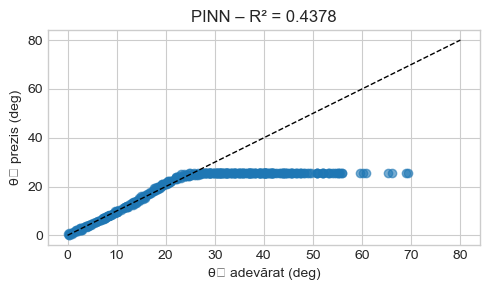

In [14]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).cpu().numpy().squeeze()
r2 = 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2)

plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred, alpha=0.6, color="C0")
plt.plot([0, 80], [0, 80], "k--", lw=1)
plt.xlabel("θ₂ adevărat (deg)")
plt.ylabel("θ₂ prezis (deg)")
plt.title(f"PINN – R² = {r2:.4f}")
plt.tight_layout()
plt.savefig("plots/snell_physics_informed.png", dpi=300)
plt.show()